In [129]:
import os
import numpy as np
import utils
import matplotlib.pyplot as plt 

In [130]:
def convolve_im_freq(im: np.array, fft_kernel: np.array, verbose=True):
    """ Convolves the image (im) with the frequency kernel (fft_kernel),
        and returns the resulting image.

        "verbose" can be used for turning on/off visualization
        convolution

    Args:
        im: np.array of shape [H, W]
        fft_kernel: np.array of shape [H, W] 
        verbose: bool
    Returns:
        im: np.array of shape [H, W]
    """
    ### START YOUR CODE HERE ###
    # Step 1: Obtain padding parameters P and Q
    M, N = im.shape  # Original dimensions of the image
    P, Q = 2 * M, 2 * N  # Padded dimensions to avoid wraparound
    # For some fucking reason they dont want padding?! O_O

    # Step 2: Form a padded image by appending zeros to make it size P x Q
    padded_image = np.zeros((M, N))
    padded_image[:M, :N] = im

    # Step 3: Multiply by (-1)^(x+y) to center the transform
    for x in range(M):
        for y in range(N):
            padded_image[x, y] *= (-1) ** (x + y)
    
    # Step 4: Compute the FFT of the centered padded image
    fft_image = np.fft.fft2(padded_image)

    # Step 5: Prepare the FFT kernel by padding it to size P x Q if not already padded
    fft_kernel = np.fft.fftshift(fft_kernel)  # Center the kernel's low frequencies
    
    # Step 6: Perform element-wise multiplication of the FFT image and the FFT kernel
    filtered_fft_image = fft_image * fft_kernel

    # Step 7: Compute the inverse FFT and multiply by (-1)^(x+y) again
    inverse_fft_image = np.fft.ifft2(filtered_fft_image)
    processed_image = np.real(inverse_fft_image)
    for x in range(M):
        for y in range(N):
            processed_image[x, y] *= (-1) ** (x + y)

    # Step 8: Crop the result to the original image size M x N
    conv_result = processed_image[:M, :N]

    ### END YOUR CODE HERE ###

    if verbose:
        # Use plt.subplot to place two or more images beside each other
        plt.figure(figsize=(20, 4))
        
        # Original Image
        plt.subplot(1, 5, 1)
        plt.imshow(im, cmap="gray")
        plt.title("Original Image")

        # FFT Image
        plt.subplot(1, 5, 2)
        plt.imshow(np.log(np.abs(fft_image) + 1), cmap="gray")
        plt.title("FFT Image")
        
        # FFT Kernel
        plt.subplot(1, 5, 3)
        plt.imshow(np.log(np.abs(fft_kernel) + 1), cmap="gray")
        plt.title("FFT Kernel")

        # Filtered FFT Image
        plt.subplot(1, 5, 4)
        plt.imshow(np.log(np.abs(filtered_fft_image) + 1), cmap="gray")
        plt.title("Filtered FFT Image")

        # Filtered Spatial Image
        plt.subplot(1, 5, 5)
        plt.imshow(conv_result, cmap="gray")
        plt.title("Filtered Spatial Image")
        
    return conv_result


In [131]:
def create_kernel(im):
    """
    Creates a line filter in the frequency domain to block frequencies along
    the central vertical and horizontal lines

    Args:
        im: np.array of shape [H, W]
        pass_through_center_bandwidth: int, bandwidth around the center to allow pass-through
    Returns:
        kernel: np.array of shape [H, W]
    """
    # Initialize a pass-through kernel
    kernel = np.ones_like(im)
    
    # Get the center coordinates
    center_row, center_col = im.shape[0] // 2, im.shape[1] // 2
    
    # Define the width of the line to block (fixed width)
    line_width = 1  # Width of the line to block

    # Define "wiggle room" for the center signals to pass through
    pass_through_center_bandwidth = 28

    # Block the entire horizontal line except the central bandwidth
    kernel[center_row - line_width:center_row + line_width + 1, :] = 0.0
    kernel[center_row - line_width:center_row + line_width + 1,
           center_col - pass_through_center_bandwidth:center_col + pass_through_center_bandwidth + 1] = 1.0

    # Block the entire vertical line except the central bandwidth
    # NOTE: NOT IN USE
    kernel[:, center_col - line_width:center_col + line_width + 1] = 1.0 #! SHOULD BE 0.0 IF IN USE
    kernel[center_row - pass_through_center_bandwidth:center_row + pass_through_center_bandwidth + 1,
           center_col - line_width:center_col + line_width + 1] = 1.0

    # Shift the kernel to be centered in the frequency domain
    kernel = np.fft.fftshift(kernel)
    
    return kernel


(538, 464)
(538, 464)
Saving image to: image_processed\moon_filtered.png


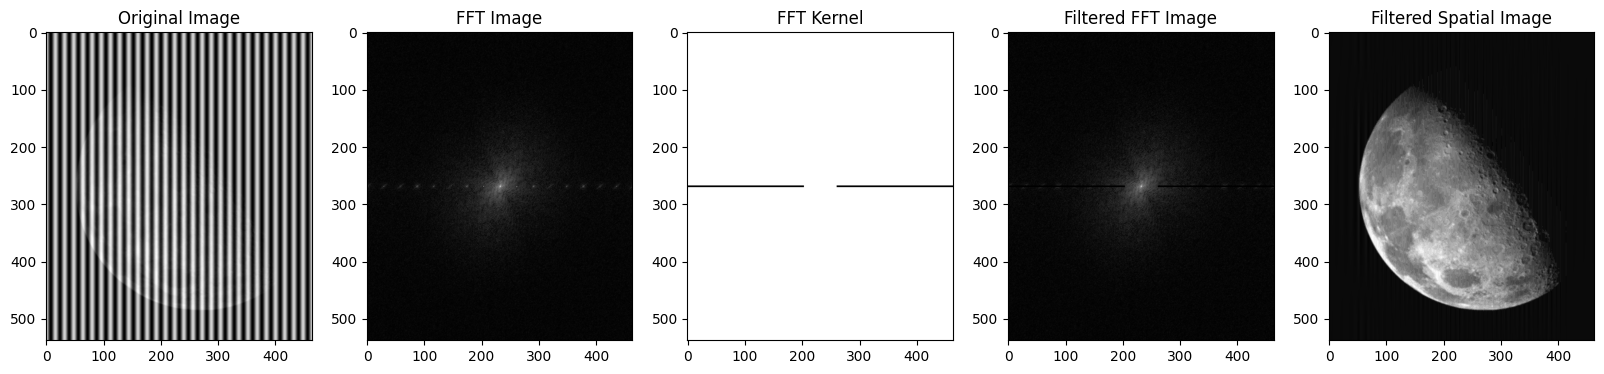

In [132]:
if __name__ == "__main__":
    # Changing this code should not be needed!
    
    impath = os.path.join("images", "noisy_moon.png")
    im = utils.read_im(impath)

    kernel = create_kernel(im)
    print(kernel.shape)   

    frequency_kernel_low_pass = utils.create_low_pass_frequency_kernel(im, radius=50)
    print(frequency_kernel_low_pass.shape)
       
    # Note that this function is from your own implementation of convolve_im_freq from freq_1.ipynb
    im_filtered = convolve_im_freq(im, kernel, verbose=True) 
    
    utils.save_im("moon_filtered.png", utils.normalize(im_filtered))